# Bayesian Network

## Inhalt
1. Initialisierung und Datenimport
2. Design des Bayesian Networks (Graph)
3. Berechnen der CPTs
4. Implementierung des Bayesian Networks
5. Test und Evaluation
6. Fazit

## 1. Initialisierung und Datenimport

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pomegranate import * # <--- muss ggf. mit pip install installiert werden

In [2]:
data = pd.read_csv('Versicherung_A1.csv', sep=';')
data.head()

,Geschlecht,Familienstand,Alter,Kinder,Bildungsstand,Beruf,Jahresgehalt,Immobilienbesitz,Versicherungstarif
0,maennlich,geschieden,53,0,Master,angestellt,95320,Eigentumswohnung,Tarif B
1,weiblich,ledig,35,1,Bachelor,arbeitend,30050,keiner,Tarif C
2,maennlich,verwitwet,34,1,Master,angestellt,76290,keiner,Tarif B
3,weiblich,geschieden,65,1,Realschule,kein,9300,keiner,ablehnen
4,maennlich,ledig,8,0,Keine,kein,0,keiner,ablehnen


## 2. Design des Bayesian Networks (Graph)

Gegeben sind 9 Variablen: Geschlecht, Familienstand, Alter, Kinder, Bildungsstand, Beruf, Jahresgehalt, Immobilienbesitz und Versicherungstarif.

In diesem Kapitel möchten wir schrittweise ein 'sinnvolles' probabilistisches Netz entwickeln. Wir starten mit folgenden Annahmen:
1. Unsere Zielvariable ist der Versicherungstarif (A, B, C oder abgelehnt).
2. Die einzigen Variablen, welche unabhängig von allen anderen Variablen sind und somit keine Elternknoten im Graph haben werden, sind **Alter** und **Geschlecht**.

Somit ergibt sich der folgende Graph.

![title](img/bayes-start.png)


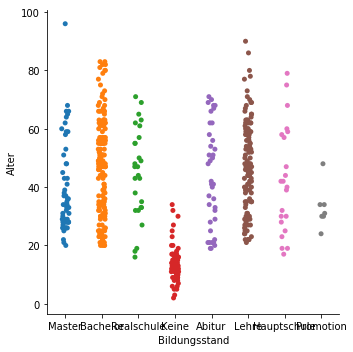

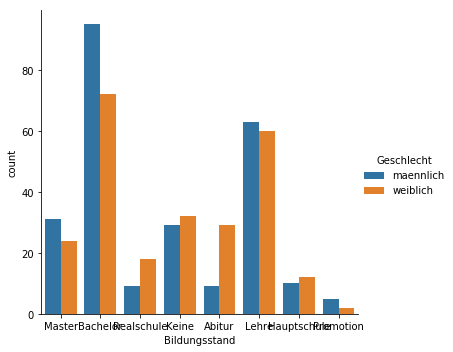

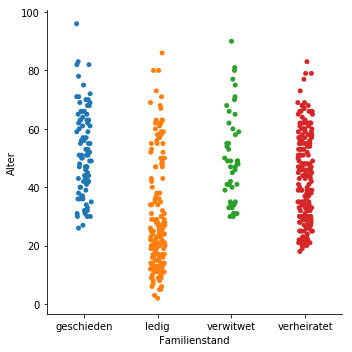

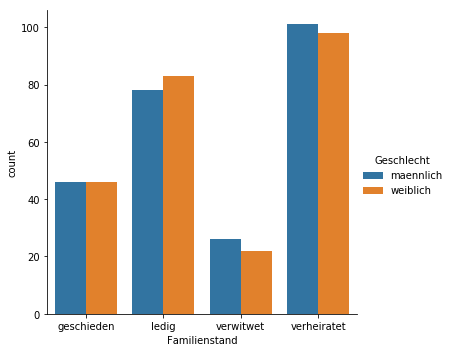

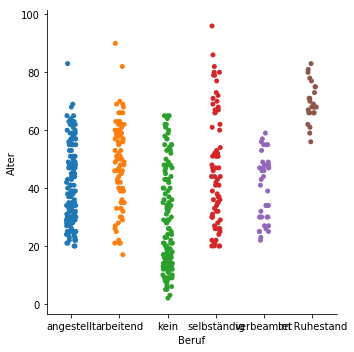

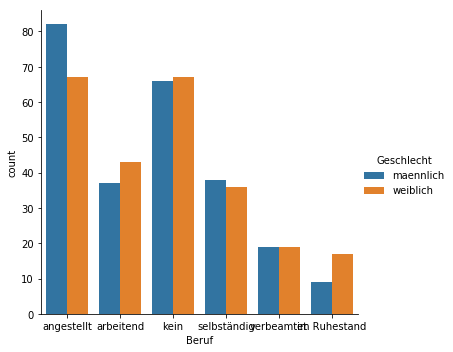

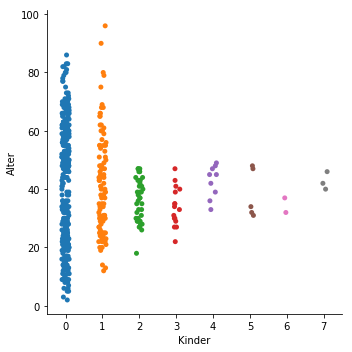

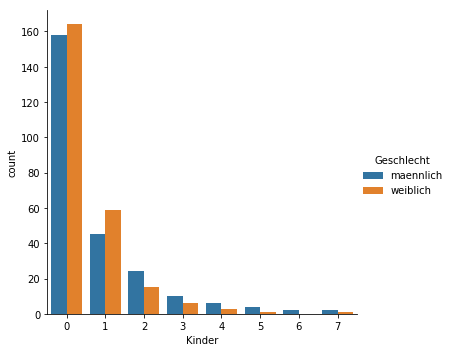

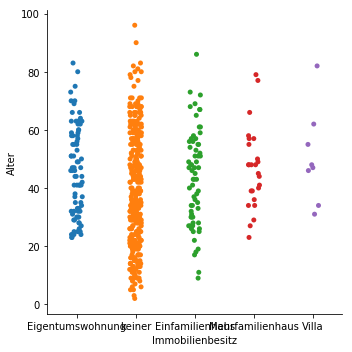

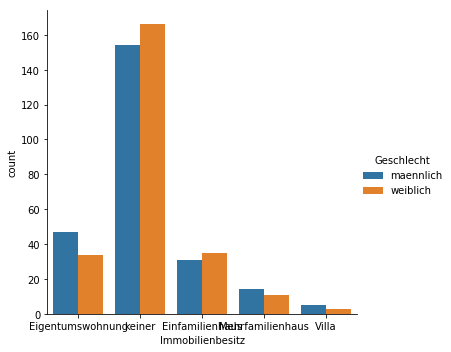

In [3]:
unknown_vars = ['Bildungsstand', 'Familienstand', 'Beruf', 'Kinder', 'Jahresgehalt', 'Immobilienbesitz']

for var in unknown_vars:
    if var == 'Jahresgehalt':
        pass
    else:
        sns.catplot(x=var, y='Alter', data=data)
        sns.catplot(x=var, hue='Geschlecht', data=data, kind='count')

In [4]:
data.groupby('Geschlecht').describe()['Jahresgehalt']

,count,mean,std,min,25%,50%,75%,max
Geschlecht,,,,,,,,
maennlich,251.0,47417.370518,34036.577188,0.0,9600.0,46600.0,75272.5,122360.0
weiblich,249.0,45552.489960,33981.708063,0.0,9800.0,35155.0,73700.0,137780.0


Aus den obigen Plots lesen wir folgende Dinge ab:
1. Die Verteilungen der einzelnen Kategorien sind stark geprägt durch das **Alter** der Personen. Wir gehen davon aus, dass das Alter aufgrund der zugrundeliegenden Biologie und gesetzlichen Normen der direkte Elternknoten von jedem einzelnen anderen Knoten ist.
2. Insbesondere können wir beim **Alter** mehrere 'Levels' erkennen: Personen unter 20 Jahre und Personen über 65 Jahre können jeweils gesondert betrachtet werden.
3. Das **Geschlecht** macht meist nur einen geringen Unterschied aus. Allerdings können wir auch hier eine leicht ungleichmäßige Verteilung feststellen, insbesondere bei **Bildungsstand**, **Immobilienbesitz** und **Beruf**.

Weiterhin treffen wir folgende Annahmen:
1. Ein weiterer Elternknoten von **Beruf** ist der **Bildungsstand** der Person.
2. Die Elternknoten von Gehalt sind neben dem **Alter** der **Bildungsstand** und der **Beruf** der Person. Wir stellen ebenfalls einen leichten Gender Pay Gap fest, können jedoch nicht ausschließen, ob dieser direkt durch das Geschlecht oder bereits durch die ungleichmäßigen Verteilungen beim Bildungsstand und Beruf entstanden ist.
3. Ein weiterer Elternknoten von **Immobilienbesitz** ist das **Jahresgehalt**.

Nachfolgend wollen wir bestimmen, welche Variablen sich wie auf die Wahl des Tarifs auswirkt. Zunächst betrachten wir die numerischen Variablen und können aus den folgenden vier Plots folgende Dinge ablesen:
1. Niemand unter 20 Jahre erhält einen Tarif (alle unter 20 werden abgelehnt).
2. Niemand mit einem Gehalt unter 10000 erhält einen Tarif
3. Niemand mit mehr als 2 Kindern erhält Tarif **A**. Wir denken jedoch nicht, dass die Kinderanzahl ausschlaggebend für den Tarif ist, sondern der Besitz einer Immobilie. Der letzte Plot zeigt, dass große Ähnlichkeiten zwischen Kinder-vs.-Tarif und Kinder-vs.-Immobilienbesitz bestehen.

Wir schließen daraus, dass diese Geschlecht und Gehalt direkte Elternknoten für den Tarif sind, Kinder jedoch nicht. Wir nehmen außerdem Kinder als zusätzlichen Elternknoten für Immobilien auf.

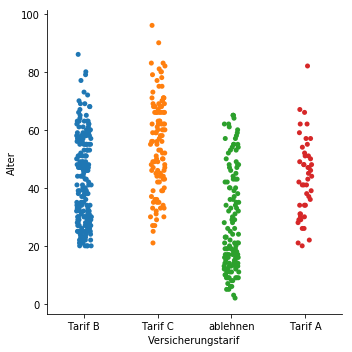

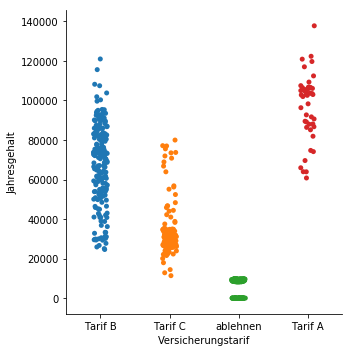

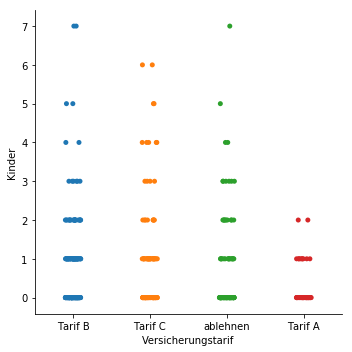

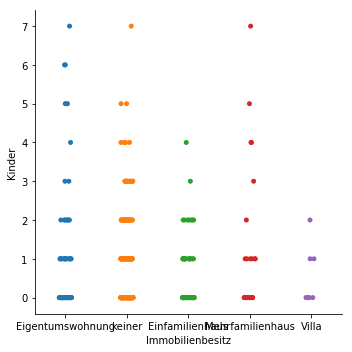

In [5]:
cont_vars = ['Alter', 'Jahresgehalt', 'Kinder']

for cont in cont_vars:
    sns.catplot(x='Versicherungstarif', y=cont, data=data)
    
sns.catplot(x='Immobilienbesitz', y='Kinder', data=data)

Es ergibt sich folgender Graph:
![title](img/bayes-mid.png)

Für die restlichen (kategorischen) Variablen berechnen wir die bedingte Wahrscheinlichkeit, einen der Tarife zu bekommen, gegeben dass jeweils eine der restlichen Variablen eintritt. Dadurch soll verhindert werden, dass wir einen Elternknoten für Tarife aufnehmen, der eigentlich besser nur indirekt wirkt (Großvater/Urgroßvater/...).

Für die kategorischen Variablen benutzen wir one-hot encoding, sodass für jede Kategorie eine einzelne True/False Spalte erzeugt wird.

In [6]:
# one-hot encoding
data_dummies = pd.get_dummies(data)
data_dummies.head()

,Alter,Kinder,Jahresgehalt,Geschlecht_maennlich,Geschlecht_weiblich,Familienstand_geschieden,Familienstand_ledig,Familienstand_verheiratet,Familienstand_verwitwet,Bildungsstand_Abitur,...,Beruf_verbeamtet,Immobilienbesitz_Eigentumswohnung,Immobilienbesitz_Einfamilienhaus,Immobilienbesitz_Mehrfamilienhaus,Immobilienbesitz_Villa,Immobilienbesitz_keiner,Versicherungstarif_Tarif A,Versicherungstarif_Tarif B,Versicherungstarif_Tarif C,Versicherungstarif_ablehnen
0,53,0,95320,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,35,1,30050,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,34,1,76290,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,65,1,9300,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,8,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


$P(A|B) = \frac{P(A und B)}{P(B)}$	

Ereignis A ist unsere Zielvariable, also Tarif A, Tarif B, Tarif C, oder ablehnen.  
Ereignis B sind unsere unabhängigen Variablen; für's erste wir nehmen hierfür alle categorical Variablen.  
  
Wir iterieren über alle Zielvariablen und unabhängigen Variablen, und berechnen für jede Kombination die bedingte Wahrscheinlichkeit.

In [7]:
data_dummies.columns

Index(['Alter', 'Kinder', 'Jahresgehalt', 'Geschlecht_maennlich',
       'Geschlecht_weiblich', 'Familienstand_geschieden',
       'Familienstand_ledig', 'Familienstand_verheiratet',
       'Familienstand_verwitwet', 'Bildungsstand_Abitur',
       'Bildungsstand_Bachelor', 'Bildungsstand_Hauptschule',
       'Bildungsstand_Keine', 'Bildungsstand_Lehre', 'Bildungsstand_Master',
       'Bildungsstand_Promotion', 'Bildungsstand_Realschule',
       'Beruf_angestellt', 'Beruf_arbeitend', 'Beruf_im Ruhestand',
       'Beruf_kein', 'Beruf_selbständig', 'Beruf_verbeamtet',
       'Immobilienbesitz_Eigentumswohnung', 'Immobilienbesitz_Einfamilienhaus',
       'Immobilienbesitz_Mehrfamilienhaus', 'Immobilienbesitz_Villa',
       'Immobilienbesitz_keiner', 'Versicherungstarif_Tarif A',
       'Versicherungstarif_Tarif B', 'Versicherungstarif_Tarif C',
       'Versicherungstarif_ablehnen'],
      dtype='object')

In [8]:
# categorical input variables
cat_columns = ['Geschlecht_maennlich', 'Geschlecht_weiblich', 'Familienstand_geschieden',
       'Familienstand_ledig', 'Familienstand_verheiratet',
       'Familienstand_verwitwet', 'Bildungsstand_Abitur',
       'Bildungsstand_Bachelor', 'Bildungsstand_Hauptschule',
       'Bildungsstand_Keine', 'Bildungsstand_Lehre', 'Bildungsstand_Master',
       'Bildungsstand_Promotion', 'Bildungsstand_Realschule',
       'Beruf_angestellt', 'Beruf_arbeitend', 'Beruf_im Ruhestand',
       'Beruf_kein', 'Beruf_selbständig', 'Beruf_verbeamtet',
       'Immobilienbesitz_Eigentumswohnung', 'Immobilienbesitz_Einfamilienhaus',
       'Immobilienbesitz_Mehrfamilienhaus', 'Immobilienbesitz_Villa',
       'Immobilienbesitz_keiner']

In [9]:
total = len(data)
total

500

In [10]:
# Calculating P(A)

target_variables = ['Versicherungstarif_Tarif A',
       'Versicherungstarif_Tarif B', 'Versicherungstarif_Tarif C',
       'Versicherungstarif_ablehnen']

p_A = {}

for target in target_variables:
    p_A[target] = data_dummies[target].sum()/total
    
p_A

{'Versicherungstarif_Tarif A': 0.094,
 'Versicherungstarif_Tarif B': 0.416,
 'Versicherungstarif_Tarif C': 0.222,
 'Versicherungstarif_ablehnen': 0.268}

In [11]:
# Calculating P(B)

p_B = {}

for cat in cat_columns:
    p_B[cat] = data_dummies[cat].sum()/total
    
p_B

{'Geschlecht_maennlich': 0.502,
 'Geschlecht_weiblich': 0.498,
 'Familienstand_geschieden': 0.184,
 'Familienstand_ledig': 0.322,
 'Familienstand_verheiratet': 0.398,
 'Familienstand_verwitwet': 0.096,
 'Bildungsstand_Abitur': 0.076,
 'Bildungsstand_Bachelor': 0.334,
 'Bildungsstand_Hauptschule': 0.044,
 'Bildungsstand_Keine': 0.122,
 'Bildungsstand_Lehre': 0.246,
 'Bildungsstand_Master': 0.11,
 'Bildungsstand_Promotion': 0.014,
 'Bildungsstand_Realschule': 0.054,
 'Beruf_angestellt': 0.298,
 'Beruf_arbeitend': 0.16,
 'Beruf_im Ruhestand': 0.052,
 'Beruf_kein': 0.266,
 'Beruf_selbständig': 0.148,
 'Beruf_verbeamtet': 0.076,
 'Immobilienbesitz_Eigentumswohnung': 0.162,
 'Immobilienbesitz_Einfamilienhaus': 0.132,
 'Immobilienbesitz_Mehrfamilienhaus': 0.05,
 'Immobilienbesitz_Villa': 0.016,
 'Immobilienbesitz_keiner': 0.64}

In [12]:
# Calculating P(A and B)

p_A_and_B = {}

for target in target_variables:
    for cat in cat_columns:
        b = data_dummies[cat] == 1
        a = data_dummies[target] == 1
        p_A_and_B[f'{target}_and_{cat}'] = len(data_dummies[a&b])/total
        
p_A_and_B

{'Versicherungstarif_Tarif A_and_Geschlecht_maennlich': 0.038,
 'Versicherungstarif_Tarif A_and_Geschlecht_weiblich': 0.056,
 'Versicherungstarif_Tarif A_and_Familienstand_geschieden': 0.01,
 'Versicherungstarif_Tarif A_and_Familienstand_ledig': 0.032,
 'Versicherungstarif_Tarif A_and_Familienstand_verheiratet': 0.042,
 'Versicherungstarif_Tarif A_and_Familienstand_verwitwet': 0.01,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Abitur': 0.004,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Bachelor': 0.046,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Hauptschule': 0.002,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Keine': 0.0,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Lehre': 0.014,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Master': 0.022,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Promotion': 0.002,
 'Versicherungstarif_Tarif A_and_Bildungsstand_Realschule': 0.004,
 'Versicherungstarif_Tarif A_and_Beruf_angestellt': 0.064,
 'Versicherungstarif_Tarif A_and_Beruf_ar

In [13]:
# Calculating P(A|B) = P(A and B)/P(B)

p_A_given_B = {}

for target in target_variables:
    for cat in cat_columns:
        p_A_given_B[f'{target}_given_{cat}'] = p_A_and_B[f'{target}_and_{cat}']/p_B[cat]

        
p_A_given_B

{'Versicherungstarif_Tarif A_given_Geschlecht_maennlich': 0.07569721115537849,
 'Versicherungstarif_Tarif A_given_Geschlecht_weiblich': 0.11244979919678715,
 'Versicherungstarif_Tarif A_given_Familienstand_geschieden': 0.05434782608695653,
 'Versicherungstarif_Tarif A_given_Familienstand_ledig': 0.09937888198757763,
 'Versicherungstarif_Tarif A_given_Familienstand_verheiratet': 0.10552763819095477,
 'Versicherungstarif_Tarif A_given_Familienstand_verwitwet': 0.10416666666666667,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Abitur': 0.052631578947368425,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Bachelor': 0.1377245508982036,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Hauptschule': 0.045454545454545456,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Keine': 0.0,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Lehre': 0.05691056910569106,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Master': 0.19999999999999998,
 'Versicherungstarif_Tarif A_given_Bildungsstand_Pro

Wir testen mit folgender Formel, ob manche der Zielereignisse unabhängig (oder nur schwach abhängig) von Inputvariablen sind und filtern diese Inputvariablen heraus. Diese Inputvariablen können nicht mehr direkte Elternknoten für den Tarif werden.

$P(A|B) \approx P(A)$; 

Oder etwas präziser: wir definieren die Ereignisse A und B als unabhängig ("nicht genug abhängig"), falls $0.8 < \frac{P(A|B)}{P(A)} < 1.25$


In [14]:
# Checking for stochastic independence
for target in target_variables:
    for cat in cat_columns:
        ratio = p_A_given_B[f'{target}_given_{cat}'] / p_A[target]
        if 4/5 < ratio < 5/4:
            print(f'{target[19:]} - {cat}')

Tarif A - Geschlecht_maennlich
Tarif A - Geschlecht_weiblich
Tarif A - Familienstand_ledig
Tarif A - Familienstand_verheiratet
Tarif A - Familienstand_verwitwet
Tarif B - Geschlecht_maennlich
Tarif B - Geschlecht_weiblich
Tarif B - Familienstand_geschieden
Tarif B - Familienstand_ledig
Tarif B - Familienstand_verheiratet
Tarif B - Familienstand_verwitwet
Tarif B - Bildungsstand_Hauptschule
Tarif B - Bildungsstand_Lehre
Tarif C - Geschlecht_maennlich
Tarif C - Geschlecht_weiblich
Tarif C - Familienstand_verheiratet
Tarif C - Bildungsstand_Bachelor
Tarif C - Bildungsstand_Hauptschule
ablehnen - Geschlecht_maennlich
ablehnen - Geschlecht_weiblich
ablehnen - Bildungsstand_Hauptschule
ablehnen - Bildungsstand_Lehre


Aus obiger Liste ziehen wir folgende Schlüße:
1. Die Tarife sind unabhängig vom **Geschlecht**. Somit ist **Geschlecht** kein direkter Elternknoten vom Tarif.
2. Manche Tarife sind teilweise unabhängig von **Familienstand** und **Bildungsstand**. Wir entscheiden uns dazu, den Familienstand als Elternknoten vom Tarif zu behalten; den Bildungsstand aber nicht als Elternknoten aufzunehmen, da der Bildungsstand noch indirekt über Gehalt und Beruf mit dem Tarif verwandt ist.
3. Alle Tarife *sind abhängig* von den kategorischen Variablen **Immobilienbesitz** und **Beruf**, sodass wir diese zwei Knoten als Elternknoten einbauen.

Es ergibt sich folgender finaler Graph.
![title](img/bayes-end.png)


# 3. Berechnen der CPTs

Mit folgender Funktion *P()* und Klasse *Vertex* können wir sehr einfach die bedingten Wahrscheinlichkeiten für alle Nodes ausrechnen (CPT).

In [15]:
import itertools

def P(query):
    total = len(data)
    x = data.query(query)
    return len(x)/total

# P('Geschlecht=="maennlich"')
# >>> 0.502

class Vertex:
    
    def __init__(self, name, s):
        self.name = name
        self.parents = []
        self.states = s
        self.cpt = None
        
    # Adds a new parent to the node
    def register_parent(self, vertex):
        self.parents.append(vertex)
        
    # Updates the CPT
    def update_cpt(self):
        
        states = [];

        # Check if node has parents
        if len(self.parents) > 0:
            
            for p in self.parents:
                states.append(p.states)
                
            states.append(self.states)
            
            permutations_tuples = list(itertools.product(*states))
            self.cpt = []
            
            for p in permutations_tuples:
                self.cpt.append(list(p))
                            
            for row in self.cpt:
                given = " & ".join(row[:-1])
                
                if P(given) == 0:
                    row.append(0)
                else:
                    prob = P(" & ".join(row))/P(given)
                    row.append(prob)
                            
        # If node has no parents, just calculate the 'normal' probability P(s)
        else:
            states = [[s] for s in self.states]
            for s in states:
                s.append(P(s[0]))
            self.cpt = states
            
    def print_cpt(self):
        columns = [p.name for p in self.parents]
        columns.append(self.name)
        columns.append('Prob')
        return pd.DataFrame(self.cpt, columns = columns)

### Alter
Wie zuvor angedeutet möchten wir das Alter in 3 Klassen aufteilen:
1. Personen unter 20
2. Personen zwischen 20 und 65
3. Personen >= 65

Hierzu rechnen wir die CPT aus (ohne condition, da keine parent node da ist) und überprüfen das Ergebnis kurz von Hand.

In [16]:
age = Vertex('Alter', ['Alter < 20', 'Alter >=20 & Alter < 65', 'Alter>=65'])
age.update_cpt()
age.print_cpt()

,Alter,Prob
0,Alter < 20,0.122
1,Alter >=20 & Alter < 65,0.764
2,Alter>=65,0.114


In [17]:
# Herausfiltern aller Personen unter 20 Jahre
u20 = data[data['Alter'] < 20]
# Anzahl der herausgefilterten Datensätze durch Gesamtzahl teilen
print(len(u20)/len(data))

# Gleiches für die beiden anderen Altersgruppen
ue20 = data[(data['Alter'] >= 20) & (data['Alter'] < 65)]
print(len(ue20)/len(data))

ue65 = data[data['Alter'] >= 65]
print(len(ue65)/len(data))

# ==> Ergebnis stimmt mit obiger Tabelle überein

0.122
0.764
0.114


### Geschlecht

Wir machen das gleiche mit Geschlecht, allerdings ohne Kontrolle, da es erneut keine bedingte Wahrscheinlichkeit zum Berechnen gibt.

In [18]:
sex = Vertex('Geschlecht', ['Geschlecht=="maennlich"', 'Geschlecht=="weiblich"'])
sex.update_cpt()
sex.print_cpt()

,Geschlecht,Prob
0,"Geschlecht==""maennlich""",0.502
1,"Geschlecht==""weiblich""",0.498


### Familienstand

Wir berechnen die bedingte Wahrscheinlichkeit für Familienstand und Alter und überprüfen das Ergebnis stichprobenartig, da es dieses Mal ein Elternknoten gibt.  
$P(Familienstand | Alter)$

In [19]:
familienstand = Vertex('Familienstand', ['Familienstand=="ledig"', 'Familienstand=="geschieden"',
                      'Familienstand=="verwitwet"', 'Familienstand=="verheiratet"'])
familienstand.register_parent(age)
familienstand.update_cpt()
familienstand.print_cpt()

,Alter,Familienstand,Prob
0,Alter < 20,"Familienstand==""ledig""",0.967213
1,Alter < 20,"Familienstand==""geschieden""",0.000000
2,Alter < 20,"Familienstand==""verwitwet""",0.000000
3,Alter < 20,"Familienstand==""verheiratet""",0.032787
4,Alter >=20 & Alter < 65,"Familienstand==""ledig""",0.246073
5,Alter >=20 & Alter < 65,"Familienstand==""geschieden""",0.188482
6,Alter >=20 & Alter < 65,"Familienstand==""verwitwet""",0.099476
7,Alter >=20 & Alter < 65,"Familienstand==""verheiratet""",0.465969
8,Alter>=65,"Familienstand==""ledig""",0.140351
9,Alter>=65,"Familienstand==""geschieden""",0.350877


In [20]:
# P(A|B) = P(A und B)/P(B)
# A: ledig
# B: <20 Jahre
# ==> Erste Zeile im DataFrame

print('P(A und B)')
print(P('Familienstand=="ledig" & Alter < 20'))
l_u20 = data[(data['Alter'] < 20) & (data['Familienstand'] == 'ledig')]
print(len(l_u20)/len(data))

print('\nP(B)')
print(P('Alter < 20')) ### Haben wir bereits ganz oben beim Alter überprüft --> 0.122


print('P(A|B) = P(A und B)/P(B)')
print(P('Familienstand=="ledig" & Alter < 20')/P('Alter < 20')) # --> Stimmt mit Ergebnis in Tabelle überein

P(A und B)
0.118
0.118

P(B)
0.122
P(A|B) = P(A und B)/P(B)
0.9672131147540983


## Kinder
Wir teilen die Personen in zwei Gruppen auf:
1. Personen mit <3 Kindern
2. Personen mit >=3 Kindern

In [21]:
kinder = Vertex('Kinder', ['Kinder < 3', 'Kinder >= 3'])
kinder.register_parent(age)
kinder.update_cpt()
kinder.print_cpt()

,Alter,Kinder,Prob
0,Alter < 20,Kinder < 3,1.000000
1,Alter < 20,Kinder >= 3,0.000000
2,Alter >=20 & Alter < 65,Kinder < 3,0.908377
3,Alter >=20 & Alter < 65,Kinder >= 3,0.091623
4,Alter>=65,Kinder < 3,1.000000
5,Alter>=65,Kinder >= 3,0.000000


## Bildungsstand
Dieses Mal wieder mit Überprüfung, da mehrere Elternteile.


In [22]:
states = [f'Bildungsstand=="{x}"' for x in data['Bildungsstand'].unique()]

education = Vertex('Bildungsstand', states)
education.register_parent(age)
education.register_parent(sex)
education.update_cpt()
education.print_cpt()

,Alter,Geschlecht,Bildungsstand,Prob
0,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""",0.000000
1,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Bachelor""",0.000000
2,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Realschule""",0.062500
3,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Keine""",0.843750
4,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Abitur""",0.031250
5,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Lehre""",0.000000
6,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Hauptschule""",0.062500
7,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Promotion""",0.000000
8,Alter < 20,"Geschlecht==""weiblich""","Bildungsstand==""Master""",0.000000
9,Alter < 20,"Geschlecht==""weiblich""","Bildungsstand==""Bachelor""",0.000000


In [23]:
# Test, ob Bachelor & 20-65 & weiblich stimmt
p_a_und_b = P('Bildungsstand=="Bachelor" & Alter >=20 & Alter < 65 & Geschlecht=="weiblich"')
p_b = P('Alter >=20 & Alter < 65 & Geschlecht=="weiblich"')
print(p_a_und_b / p_b) # ---> Stimmt

0.328042328042328


## Beruf

In [24]:
states = [f'Beruf=="{x}"' for x in data['Beruf'].unique()]

beruf = Vertex('Beruf', states)
beruf.register_parent(age)
beruf.register_parent(sex)
beruf.register_parent(education)
beruf.update_cpt()
beruf.print_cpt()

,Alter,Geschlecht,Bildungsstand,Beruf,Prob
0,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""","Beruf==""angestellt""",0.000000
1,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""","Beruf==""arbeitend""",0.000000
2,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""","Beruf==""kein""",0.000000
3,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""","Beruf==""selbständig""",0.000000
4,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""","Beruf==""verbeamtet""",0.000000
5,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Master""","Beruf==""im Ruhestand""",0.000000
6,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Bachelor""","Beruf==""angestellt""",0.000000
7,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Bachelor""","Beruf==""arbeitend""",0.000000
8,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Bachelor""","Beruf==""kein""",0.000000
9,Alter < 20,"Geschlecht==""maennlich""","Bildungsstand==""Bachelor""","Beruf==""selbständig""",0.000000


## Jahresgehalt
Wir erstellen erneut mehrere diskrete Gruppen:
1. Personen mit < 10000
2. Personen mit >= 10000 & < 60000
3. Personen mit >= 60000 & < 80000
4. Personen mit >= 80000 & < 100000
5. Personen mit > 100000

In [25]:
states =  ['Jahresgehalt < 10000', 'Jahresgehalt >= 10000 & Jahresgehalt < 60000',
           'Jahresgehalt >= 60000 & Jahresgehalt < 80000',
           'Jahresgehalt >= 80000 & Jahresgehalt < 100000',
           'Jahresgehalt >= 100000']

gehalt = Vertex('Jahresgehalt', states)
gehalt.register_parent(age)
gehalt.register_parent(education)
gehalt.register_parent(beruf)
gehalt.update_cpt()
gehalt.print_cpt()

,Alter,Bildungsstand,Beruf,Jahresgehalt,Prob
0,Alter < 20,"Bildungsstand==""Master""","Beruf==""angestellt""",Jahresgehalt < 10000,0.0
1,Alter < 20,"Bildungsstand==""Master""","Beruf==""angestellt""",Jahresgehalt >= 10000 & Jahresgehalt < 60000,0.0
2,Alter < 20,"Bildungsstand==""Master""","Beruf==""angestellt""",Jahresgehalt >= 60000 & Jahresgehalt < 80000,0.0
3,Alter < 20,"Bildungsstand==""Master""","Beruf==""angestellt""",Jahresgehalt >= 80000 & Jahresgehalt < 100000,0.0
4,Alter < 20,"Bildungsstand==""Master""","Beruf==""angestellt""",Jahresgehalt >= 100000,0.0
5,Alter < 20,"Bildungsstand==""Master""","Beruf==""arbeitend""",Jahresgehalt < 10000,0.0
6,Alter < 20,"Bildungsstand==""Master""","Beruf==""arbeitend""",Jahresgehalt >= 10000 & Jahresgehalt < 60000,0.0
7,Alter < 20,"Bildungsstand==""Master""","Beruf==""arbeitend""",Jahresgehalt >= 60000 & Jahresgehalt < 80000,0.0
8,Alter < 20,"Bildungsstand==""Master""","Beruf==""arbeitend""",Jahresgehalt >= 80000 & Jahresgehalt < 100000,0.0
9,Alter < 20,"Bildungsstand==""Master""","Beruf==""arbeitend""",Jahresgehalt >= 100000,0.0


## Immobilienbesitz

In [26]:
states = [f'Immobilienbesitz=="{x}"' for x in data['Immobilienbesitz'].unique()]


immobilie = Vertex("Immobilienbesitz", states)
immobilie.register_parent(age)
immobilie.register_parent(sex)
immobilie.register_parent(kinder)
immobilie.register_parent(gehalt)
immobilie.update_cpt()
immobilie.print_cpt()

,Alter,Geschlecht,Kinder,Jahresgehalt,Immobilienbesitz,Prob
0,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt < 10000,"Immobilienbesitz==""Eigentumswohnung""",0.00000
1,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt < 10000,"Immobilienbesitz==""keiner""",0.90625
2,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt < 10000,"Immobilienbesitz==""Einfamilienhaus""",0.09375
3,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt < 10000,"Immobilienbesitz==""Mehrfamilienhaus""",0.00000
4,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt < 10000,"Immobilienbesitz==""Villa""",0.00000
5,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt >= 10000 & Jahresgehalt < 60000,"Immobilienbesitz==""Eigentumswohnung""",0.00000
6,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt >= 10000 & Jahresgehalt < 60000,"Immobilienbesitz==""keiner""",0.00000
7,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt >= 10000 & Jahresgehalt < 60000,"Immobilienbesitz==""Einfamilienhaus""",0.00000
8,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt >= 10000 & Jahresgehalt < 60000,"Immobilienbesitz==""Mehrfamilienhaus""",0.00000
9,Alter < 20,"Geschlecht==""maennlich""",Kinder < 3,Jahresgehalt >= 10000 & Jahresgehalt < 60000,"Immobilienbesitz==""Villa""",0.00000


## Tarif

In [27]:
states = [f'Versicherungstarif=="{x}"' for x in data['Versicherungstarif'].unique()]

tarif = Vertex("Versicherungstarif", states)
tarif.register_parent(age)
tarif.register_parent(familienstand)
tarif.register_parent(beruf)
tarif.register_parent(gehalt)
tarif.register_parent(immobilie)
tarif.update_cpt()
tarif.print_cpt()

,Alter,Familienstand,Beruf,Jahresgehalt,Immobilienbesitz,Versicherungstarif,Prob
0,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""Eigentumswohnung""","Versicherungstarif==""Tarif B""",0.0
1,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""Eigentumswohnung""","Versicherungstarif==""Tarif C""",0.0
2,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""Eigentumswohnung""","Versicherungstarif==""ablehnen""",0.0
3,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""Eigentumswohnung""","Versicherungstarif==""Tarif A""",0.0
4,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""keiner""","Versicherungstarif==""Tarif B""",0.0
5,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""keiner""","Versicherungstarif==""Tarif C""",0.0
6,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""keiner""","Versicherungstarif==""ablehnen""",0.0
7,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""keiner""","Versicherungstarif==""Tarif A""",0.0
8,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""Einfamilienhaus""","Versicherungstarif==""Tarif B""",0.0
9,Alter < 20,"Familienstand==""ledig""","Beruf==""angestellt""",Jahresgehalt < 10000,"Immobilienbesitz==""Einfamilienhaus""","Versicherungstarif==""Tarif C""",0.0



# 4. Implementierung des Bayesian Networks

In [28]:
# Defining probability distributions
sex_cpt = DiscreteDistribution({'Geschlecht=="maennlich"': 0.502, 'Geschlecht=="weiblich"': 0.498})
age_cpt = DiscreteDistribution({"Alter < 20": 0.122, "Alter >=20 & Alter < 65": 0.764, "Alter>=65": 0.114})
familienstand_cpt = ConditionalProbabilityTable(familienstand.cpt, [age_cpt])
kinder_cpt = ConditionalProbabilityTable(kinder.cpt, [age_cpt])
bildungsstand_cpt = ConditionalProbabilityTable(education.cpt, [age_cpt, sex_cpt])
beruf_cpt = ConditionalProbabilityTable(beruf.cpt, [age_cpt, sex_cpt, bildungsstand_cpt])
gehalt_cpt = ConditionalProbabilityTable(gehalt.cpt, [age_cpt, bildungsstand_cpt, beruf_cpt])
immobilie_cpt = ConditionalProbabilityTable(immobilie.cpt, [age_cpt, sex_cpt, kinder_cpt, gehalt_cpt])
tarif_cpt = ConditionalProbabilityTable(tarif.cpt, [age_cpt, familienstand_cpt, beruf_cpt, gehalt_cpt, immobilie_cpt])

# Defining nodes
sex_n = Node(sex_cpt, name="Geschlecht")
age_n = Node(age_cpt, name="Alter")
familienstand_n = Node(familienstand_cpt, name="Familienstand")
kinder_n = Node(kinder_cpt, name="Kinder")
bildungsstand_n = Node(bildungsstand_cpt, name="Bildungsstand")
beruf_n = Node(beruf_cpt, name="Beruf")
gehalt_n = Node(gehalt_cpt, name="Gehalt")
immobilie_n = Node(immobilie_cpt, name="Immobilienbesitz")
tarif_n = Node(tarif_cpt, name="Versicherungstarif")

# Init model
model = BayesianNetwork("Versicherungstarif_Netz")

# Add states
model.add_states(sex_n, familienstand_n, age_n,  kinder_n, bildungsstand_n, beruf_n, gehalt_n, immobilie_n, tarif_n)

# Add edges
# familienstand und kinder
model.add_edge(age_n, familienstand_n) 
model.add_edge(age_n, kinder_n) 

# Bildungsstand
model.add_edge(age_n, bildungsstand_n)
model.add_edge(sex_n, bildungsstand_n)

# Beruf
model.add_edge(age_n, beruf_n)
model.add_edge(sex_n, beruf_n)
model.add_edge(bildungsstand_n, beruf_n)

# Gehalt
model.add_edge(age_n, gehalt_n)
model.add_edge(bildungsstand_n, gehalt_n)
model.add_edge(beruf_n, gehalt_n)

# Immobilie
model.add_edge(age_n, immobilie_n)
model.add_edge(sex_n, immobilie_n)
model.add_edge(kinder_n, immobilie_n)
model.add_edge(gehalt_n, immobilie_n)

# Immobilie
model.add_edge(age_n, tarif_n)
model.add_edge(familienstand_n, tarif_n)
model.add_edge(beruf_n, tarif_n)
model.add_edge(gehalt_n, tarif_n)
model.add_edge(immobilie_n, tarif_n)


model.bake()

# 5. Test und Evaluation

Mit folgendem Beispielcode können Sie die fehlenden Werte von Personen vorhersagen.

In [29]:
# Hilfsklasse für Person, muss initialisiert werden
class Person:
    
    def __init__(self, df_row):
        self.geschlecht = df_row[0]
        self.familienstand = df_row[1]
        self.alter = df_row[2]
        self.kinder = df_row[3]
        self.bildungsstand = df_row[4]
        self.beruf = df_row[5]
        self.jahresgehalt = df_row[6]
        self.immobilienbesitz = df_row[7]
        self.versicherungstarif = df_row[8]
        
    def get_bayes_query(self):
        query = []
        query.append(None if self.geschlecht==None else f'Geschlecht=="{self.geschlecht}"')
        query.append(None if self.familienstand==None else f'Familienstand=="{self.familienstand}"')
        query.append(None if self.alter==None else 'Alter < 20' if self.alter < 20 
                     else 'Alter >=20 & Alter < 65' if 20 <= self.alter < 65 
                     else 'Alter>=65')
        query.append(None if self.kinder==None else 'Kinder < 3' if self.kinder < 3 else 'Kinder >= 3')
        query.append(None if self.bildungsstand==None else f'Bildungsstand=="{self.bildungsstand}"')
        query.append(None if self.beruf==None else f'Beruf=="{self.beruf}"')
        query.append(None if self.jahresgehalt==None else 'Jahresgehalt < 10000' if self.jahresgehalt < 10000
                     else 'Jahresgehalt >= 10000 & Jahresgehalt < 60000' if 10000 <= self.jahresgehalt < 60000
                     else 'Jahresgehalt >= 60000 & Jahresgehalt < 80000' if 60000 <= self.jahresgehalt < 80000
                     else 'Jahresgehalt >= 80000 & Jahresgehalt < 100000' if 80000 <= self.jahresgehalt < 100000
                     else 'Jahresgehalt >= 100000')
        query.append(None if self.immobilienbesitz==None else f'Immobilienbesitz=="{self.immobilienbesitz}"')
        query.append(None if self.versicherungstarif==None else f'Versicherungstarif=="{self.versicherungstarif}"')
        
        return query

In [30]:
# Testdatensatz
data_test = pd.read_csv('test_daten.csv', sep=";")
data_test = data_test.where(pd.notnull(data_test), None)
data_test.head()

,Geschlecht,Familienstand,Alter,Kinder,Bildungsstand,Beruf,Jahresgehalt,Immobilienbesitz,Versicherungstarif
0,maennlich,None,53,0,Master,angestellt,95320,Eigentumswohnung,Tarif B
1,weiblich,ledig,35,1,None,None,30050,keiner,Tarif C
2,maennlich,verwitwet,34,1,Master,angestellt,None,keiner,None
3,None,geschieden,None,1,None,kein,9300,keiner,ablehnen
4,maennlich,None,8,0,Keine,None,0,keiner,ablehnen


In [31]:
# Ausgabe der vorhergesagten Werte
for index, row in data_test.iterrows():
    print(index)
    p = Person(data_test.iloc[index,:])
    print(model.predict([p.get_bayes_query()]))

0
[array(['Geschlecht=="maennlich"', 'Familienstand=="verheiratet"',
       'Alter >=20 & Alter < 65', 'Kinder < 3', 'Bildungsstand=="Master"',
       'Beruf=="angestellt"',
       'Jahresgehalt >= 80000 & Jahresgehalt < 100000',
       'Immobilienbesitz=="Eigentumswohnung"',
       'Versicherungstarif=="Tarif B"'], dtype=object)]
1
[array(['Geschlecht=="weiblich"', 'Familienstand=="ledig"',
       'Alter >=20 & Alter < 65', 'Kinder < 3', 'Bildungsstand=="Lehre"',
       'Beruf=="arbeitend"',
       'Jahresgehalt >= 10000 & Jahresgehalt < 60000',
       'Immobilienbesitz=="keiner"', 'Versicherungstarif=="Tarif C"'],
      dtype=object)]
2
[array(['Geschlecht=="maennlich"', 'Familienstand=="verwitwet"',
       'Alter >=20 & Alter < 65', 'Kinder < 3', 'Bildungsstand=="Master"',
       'Beruf=="angestellt"',
       'Jahresgehalt >= 60000 & Jahresgehalt < 80000',
       'Immobilienbesitz=="keiner"', 'Versicherungstarif=="Tarif B"'],
      dtype=object)]
3
[array(['Geschlecht=="weiblich"', 

In [33]:
# Vergleich mit echten Werten
data.head()

,Geschlecht,Familienstand,Alter,Kinder,Bildungsstand,Beruf,Jahresgehalt,Immobilienbesitz,Versicherungstarif
0,maennlich,geschieden,53,0,Master,angestellt,95320,Eigentumswohnung,Tarif B
1,weiblich,ledig,35,1,Bachelor,arbeitend,30050,keiner,Tarif C
2,maennlich,verwitwet,34,1,Master,angestellt,76290,keiner,Tarif B
3,weiblich,geschieden,65,1,Realschule,kein,9300,keiner,ablehnen
4,maennlich,ledig,8,0,Keine,kein,0,keiner,ablehnen


## 6. Fazit

Mithilfe von Pomegranate und verschiedener Hilfsklassen konnten wir ein Bayesian Network entwickeln, welches einigermaßen zuverlässig fehlende Variablen vorhersagt. Basierend auf Erkenntnissen, die durch Datenvisualisierung und Unabhängigkeitstests gewonnen wurden, haben wir zunächst einen passenden Graph entwickelt. Daraufhin konnten wir die CPTs automatisiert berechnen und das Netzwerk implementieren und testen.